In [27]:
import pandas as pd
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [28]:
# Manual inputs
TIMEFRAME = "1d"
LOOKBACK_PERIOD = "5y"

# Preprocessing:

In [29]:
# Get the list of S&P500 stocks from Wikipedia
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500 = pd.read_html(URL)
tickers = sp500[0]['Symbol'].to_list()
print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CDAY', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'C

In [30]:
tickers = ['SPY'] + tickers # Add SPY to the list of tickers, will be used as a benchmark

In [31]:
stock_returns = [] # List of series
cached_returns = {} # Dictionary of dataframes

for stock in tickers:
  data = yf.Ticker(stock).history(period=LOOKBACK_PERIOD, interval=TIMEFRAME) 
  cached_returns[stock] = data
  data["returns"] =  np.log(1+data["Close"].pct_change())
  data.rename(columns={"returns": stock}, inplace=True)
  if len(data) > 0:
    stock_returns.append(data[stock])

BRK.B: No data found, symbol may be delisted
BF.B: No data found for this date range, symbol may be delisted
LMT: No data found for this date range, symbol may be delisted


In [32]:
short_listed_stocks = []

# Filter 1: Must be in uptrend
for e in stock_returns:
    drift200 = e[-200:].mean() - 0.5 * e[-200:].var()
    drift50 = e[-50:].mean() - 0.5 * e[-50:].var()
    # print(e.name, drift)
    if drift200 > 0 and drift50 > 0:
        short_listed_stocks.append(e.name)
        # print("Short listed: ", e.name)
    else:
        # print("\t(X) Not short listed: ", e.name)
        pass

### Correlation matrix

In [33]:
correl_matrix = pd.DataFrame(stock_returns).T.corr().round(4)

In [34]:
SHOW_MATRIX = False
_matrix = correl_matrix.style.background_gradient(cmap ='coolwarm')
if not SHOW_MATRIX:
  _matrix = None
_matrix

### Analysis: Market beta vs Market correlation

In [35]:
# Get data for the stock and SPY
stock = yf.Ticker("AAPL")
SPY = yf.Ticker("SPY")

def calc_beta(stock, benchmark="SPY"): 

    # Get the historical closes
    try:
        stock_hc = cached_returns[stock]
    except KeyError:
        stock_hc = yf.Ticker(stock).history(period=LOOKBACK_PERIOD)

    try: 
        benchmark_hc = cached_returns[benchmark]
    except KeyError:
        benchmark_hc = yf.Ticker(benchmark).history(period=LOOKBACK_PERIOD)

    # Calculate the daily returns for the stock and SPY
    stock_returns = stock_hc['Close'].pct_change()
    SPY_returns = benchmark_hc['Close'].pct_change()

    # Calculate the beta of the stock against SPY
    covar = stock_returns.cov(SPY_returns)
    var = SPY_returns.var()

    return covar / var # beta

In [36]:
# Calc the beta in each of the stock in short_listed_stocks
beta_map = {}
for stock in short_listed_stocks:
    beta_map[stock] = calc_beta(stock)

In [37]:
# Calc the correlation of each stock with SPY
correl_with_SPY_map = {}
for stock in short_listed_stocks:
    correl_with_SPY_map[stock] = correl_matrix[stock]["SPY"]

# Classical Machine Learning:

c:\Users\kevli\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\kevli\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


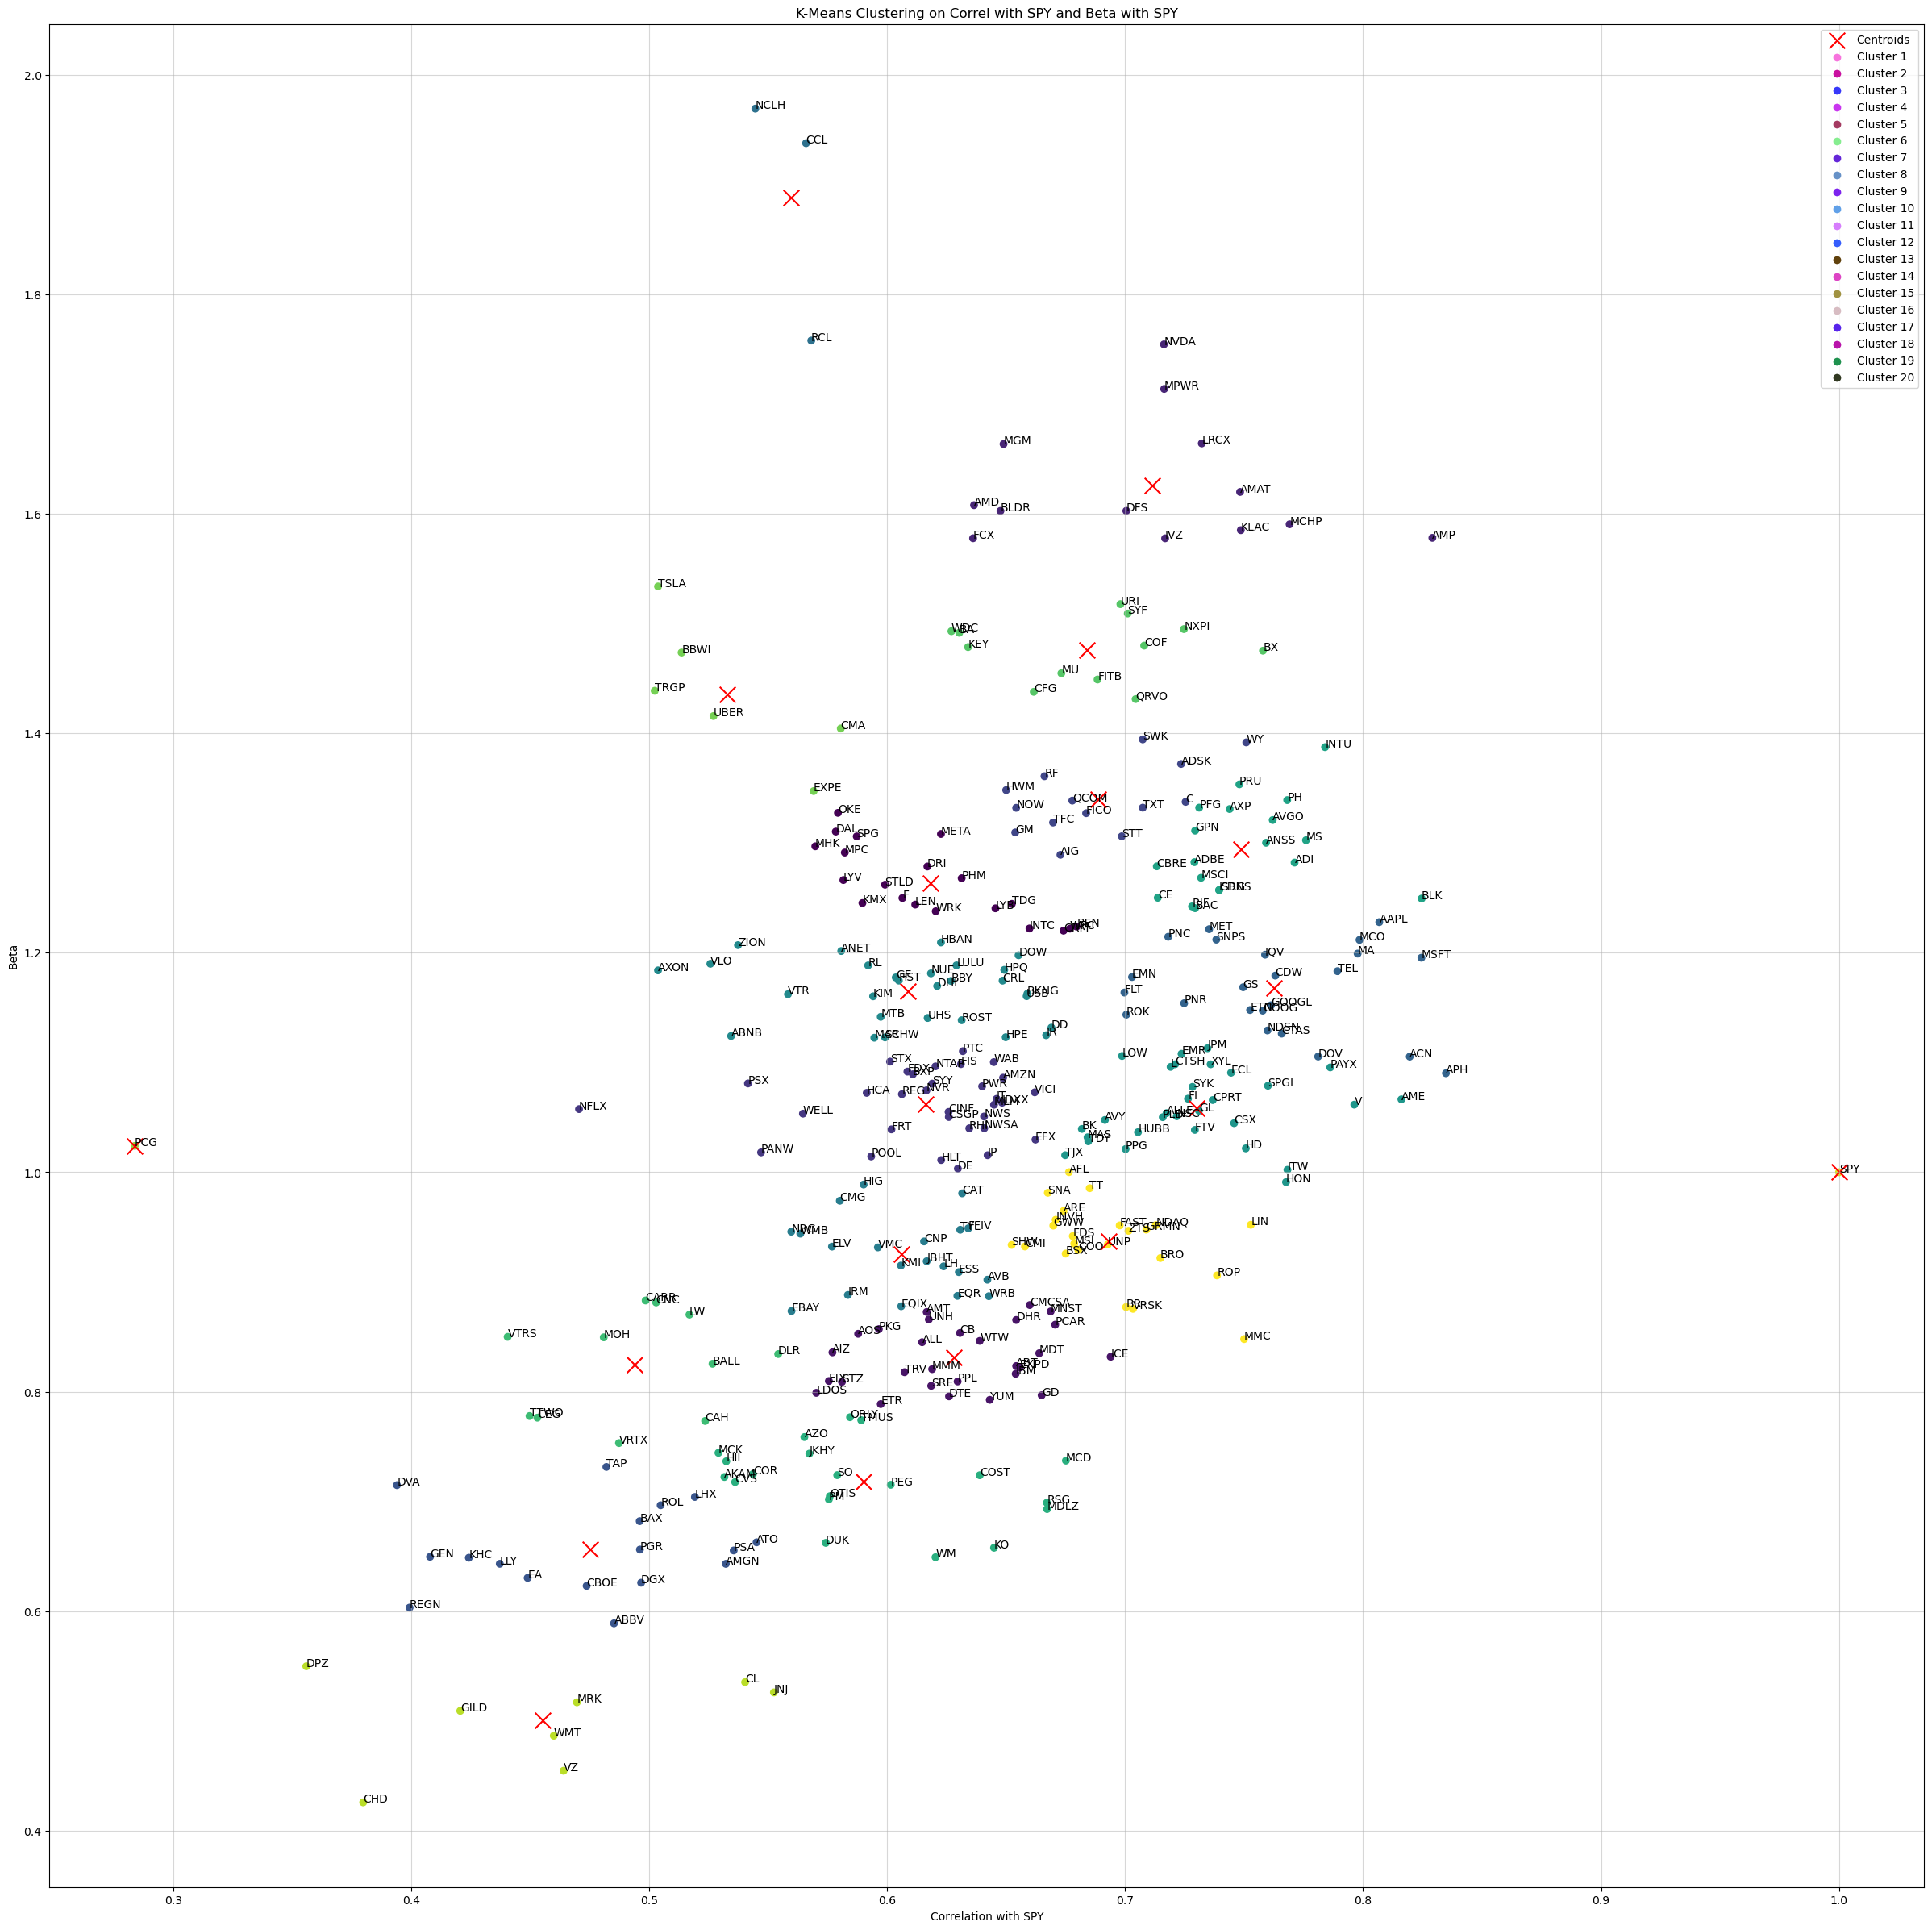

In [38]:
N_CLUSTERS = 20

# Features
X = pd.DataFrame(list(zip(correl_with_SPY_map.values(), beta_map.values())), columns=["Correl", "Beta"])

# Create a K-Means model with N_CLUSTERS clusters
kmeans = KMeans(n_clusters=N_CLUSTERS)

# Fit the model to the data
kmeans.fit(X)

# Predict the clusters
clusters = kmeans.predict(X)

# Add the clusters to the dataframe
X["Cluster"] = clusters

# Plot the clusters
plt.figure(figsize=(30, 30))
plt.scatter(X["Correl"], X["Beta"], c=X["Cluster"], cmap="viridis")
plt.xlabel("Correlation with SPY"), plt.ylabel("Beta")
plt.title("K-Means Clustering on Correl with SPY and Beta with SPY")
plt.grid(alpha=0.5)

# Add labels to each point
for label, correl in correl_with_SPY_map.items():
    beta = beta_map[label]
    plt.annotate(label, (correl, beta))

# Add the centroids to the plot
centroids = kmeans.cluster_centers_ 
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=200, c="red")

# Legend
plt.scatter([], [], marker="x", s=200, color="red", label="Centroids")
_colors = ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(N_CLUSTERS)]
for i in range(N_CLUSTERS):
    plt.scatter([], [], color=_colors[i], label="Cluster "+str(i+1))
plt.legend();

plt.show()

In [39]:
# Dataframe with rows: stock name, cluster number
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X.index.values
cluster_map['cluster'] = kmeans.labels_
cluster_map['Ticker'] = list(correl_with_SPY_map.keys())

In [40]:
def clean_data(cluster_map):
    # Sort by column: 'cluster' (ascending)
    cluster_map = cluster_map.sort_values(['cluster'])
    return cluster_map

cluster_map_clean = clean_data(cluster_map.copy())
cluster_map_clean.head()

,data_index,cluster,Ticker
230,230,0,OKE
320,320,0,WRK
90,90,0,DRI
93,93,0,DAL
270,270,0,CRM
